<a href="https://colab.research.google.com/github/Anirbit-AI/Expositions-With-PyTorch/blob/main/Demonstrating_Double_Descent_on_Nets_vs_(Absent%3F)_for_Linear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction



In [ ]:
import torch
import matplotlib.pyplot as plt
from torch import nn
import torch.utils.data as Data
from torchsummary import summary

#Preparing The Data

The training data and test data is generated by creating $x$, $x_{test}$ to be evenly spaced points between -1 and 1. Then, plugging them into the function $f(x) = x^3$  to get the labels -- and optionally adding random normal noise to the true labels.

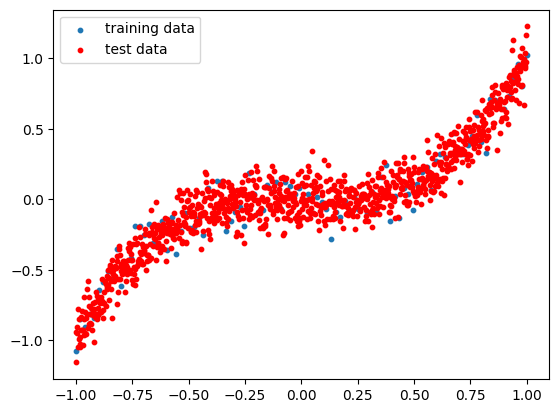

In [ ]:
training_set_size = 100
test_set_size = 1000

x = torch.reshape(torch.linspace(-1, 1,training_set_size),(training_set_size,1))
y = (x**3+.1*torch.reshape(torch.randn(training_set_size),(training_set_size,1))) #add noise to the training labels
#y = x**3


x_test = torch.reshape(torch.linspace(-1, 1,test_set_size),(test_set_size,1))
y_test = (x_test**3+.1*torch.reshape(torch.randn(test_set_size),(test_set_size,1))) #add noise to the test labels
#y_test = x_test**3

torch_dataset = Data.TensorDataset(x, y)
torch_dataset_test = Data.TensorDataset(x_test, y_test)
trainloader = torch.utils.data.DataLoader(torch_dataset, shuffle=True, batch_size=10)
testloader = torch.utils.data.DataLoader(torch_dataset_test, shuffle=True, batch_size=10)
plt.scatter(x,y, s = 10,label= "training data")
plt.scatter( x_test,y_test, c = 'red', s = 10,label = "test data")
plt.legend()

#Computing the Training & the Test Error

In [ ]:
def train(dataloader, model, loss_fn, optimizer):

    model.train()

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    return Loss(dataloader,model,loss_fn)



def Loss(dataloader, model, loss_fn):

    num_batches = len(dataloader)
    model.eval()
    loss = 0
    #, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()

    loss /= num_batches

    return loss

#Defining A Neural Network

In [ ]:
class Net(nn.Module):
    def __init__(self, layer_size):
        super(Net, self).__init__()

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, layer_size),
            nn.ReLU(),
            nn.Linear(layer_size, 1),
        )


    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

The net maps, $\mathbb{R} \ni x \mapsto {\bf A_3} {\rm ReLU}({\bf A_2} {\rm ReLU} ({\bf A_1} x ))\in \mathbb{R}$

where,

${\bf A_1} : \mathbb{R}^{1} \rightarrow \mathbb{R}^{ {\rm layer\_size}}$ is an affine map.

${\bf A_2} : \mathbb{R}^{{\rm layer\_size}} \rightarrow  \mathbb{R}^{\rm layer\_size}$ is an affine map.

and

${\bf A_3} : \mathbb{R}^{ {\rm layer\_size}} \rightarrow \mathbb{R}^{1}$ is an affine map.

##Hyperparameter Setting For the Nets & the SGD

In [ ]:
#layer_sizes = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
layer_sizes = [1,2,3,4,5,6,7,8,9,10]
runs = 2 #5
epochs = 1000

## Doing The Neural Training

In [ ]:
Train_Loss_AllSizes = []
Test_Loss_AllSizes = []

for j in range(len(layer_sizes)):
    layersize = layer_sizes[j]
    loss_for_avg_train = 0
    loss_for_avg_test = 0

    for trial in range(runs):

        model = Net(layersize)
        mse_loss = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)


        for t in range(epochs):
            train_loss = train(trainloader, model, mse_loss, optimizer)
            test_loss = Loss(testloader, model, mse_loss)

        loss_for_avg_train += train_loss/runs
        loss_for_avg_test += test_loss/runs


    Train_Loss_AllSizes.append(loss_for_avg_train)
    Test_Loss_AllSizes.append(loss_for_avg_test)
"Done!"

'Done!'

##Is There Double-Descent In Neural Regression?

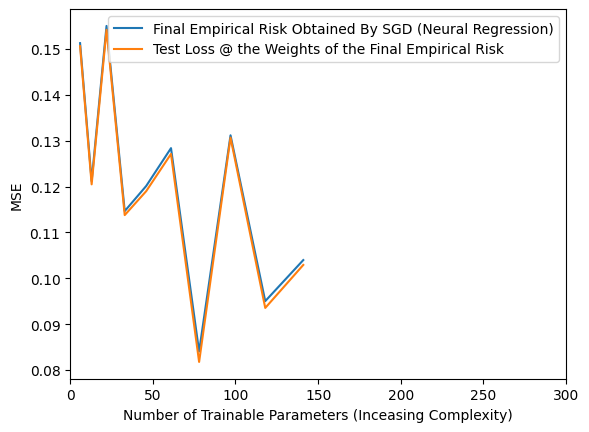

In [ ]:
fig, ax = plt.subplots()
layer_sizes=torch.tensor(layer_sizes)
net_sizes = 1 + layer_sizes**2 + 4*layer_sizes

ax.plot(net_sizes, Train_Loss_AllSizes, label = "Final Empirical Risk Obtained By SGD (Neural Regression)")
ax.plot(net_sizes, Test_Loss_AllSizes, label = "Test Loss @ the Weights of the Final Empirical Risk")

ax.set_xlim([0,300])


ax.set_xlabel('Number of Trainable Parameters (Inceasing Complexity)')
ax.set_ylabel('MSE')
fig.show()
plt.legend()

#Defining A Linear Network

In [ ]:
class LinearClass(nn.Module):
    def __init__(self, layer_size):
          super().__init__()
          self.fc1 = nn.Linear(1, layer_size)
          self.fc1.requires_grad_(False)
          self.fc2 = nn.Linear(layer_size, 1)


      #R \ni  x -> A_2 o (A1(x)) \in R
      #where A1 : R -> R^{layer_size} and A2 : R^{layer_size} -> R are affine transforms
      #Only A2 is being trained

    def forward(self, x):
          x = self.fc1(x)
          x = self.fc2(x)
          return x

##Hyperparameter Setting For the Linear Class & the SGD

In [ ]:
#layer_sizes = [2**1,2**2,2**3,2**4,2**5,2**6,2**7,2**8,300]
layer_sizes = [2**1,2**2,2**3,2**4,2**5]
runs = 5 #5
epochs = 2000

##Doing The Linear Regression

In [ ]:
Train_Loss_AllSizesL = []
Test_Loss_AllSizesL = []

for j in range(len(layer_sizes)):
    layersize = layer_sizes[j]
    loss_for_avg_train = 0
    loss_for_avg_test = 0

    for trial in range(runs):

        model = LinearClass(layersize)
        mse_loss = nn.MSELoss()
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)


        for t in range(epochs):
            train_loss = train(trainloader, model, mse_loss, optimizer)
            test_loss = Loss(testloader, model, mse_loss)

        loss_for_avg_train += train_loss/runs
        loss_for_avg_test += test_loss/runs


    Train_Loss_AllSizesL.append(loss_for_avg_train)
    Test_Loss_AllSizesL.append(loss_for_avg_test)
"Done!"

'Done!'

##Is There Double-Descent In Linear Regression?

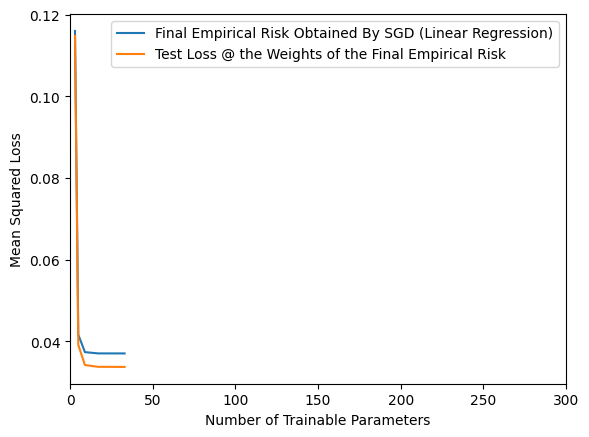

In [ ]:
fig, ax = plt.subplots()
layer_sizes=torch.tensor(layer_sizes)
net_sizes = 1 + layer_sizes

ax.plot(net_sizes, Train_Loss_AllSizesL, label = "Final Empirical Risk Obtained By SGD (Linear Regression)")
ax.plot(net_sizes, Test_Loss_AllSizesL, label = "Test Loss @ the Weights of the Final Empirical Risk")

ax.set_xlim([0,300])

ax.set_xlabel('Number of Trainable Parameters')
ax.set_ylabel('Mean Squared Loss')
fig.show()
plt.legend()